In [1]:
# The code was removed by Watson Studio for sharing.

# Coursera Course: IBM Data Science Capstone Project
## Recommendation System for Restaurants in Hyderabad under GHMC.
### By Devender Madura


### Identify all libraries required install and import them in one block

In [3]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes

import json
from pandas.io.json import json_normalize
import requests
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
import math
import geopy.geocoders
from geopy.geocoders import Nominatim
from sklearn import metrics


print ("Project Libraries Imported")

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-


### Import hyderabad locations and format the data to identify wards\neighbourhoods from wikipedia link 
#### https://en.wikipedia.org/wiki/List_of_Hyderabad_Corporation_wards

In [10]:
# Import hyderabad locations and format the data to identify wards\neighbourhoods

WikiHydHtml = pd.read_html("https://en.wikipedia.org/wiki/List_of_Hyderabad_Corporation_wards")
WikiHydHtml = WikiHydHtml[0]
print (WikiHydHtml.shape)
print (WikiHydHtml.dtypes)

WikiHydLoc = WikiHydHtml.copy(deep = True)
WikiHydLoc = WikiHydLoc.astype(str)

WikiHydLoc['Circle'] = WikiHydLoc['Circle'].str.lstrip('0123456789.--() ')
WikiHydLoc['Ward'] = WikiHydLoc['Ward'].str.lstrip('0123456789.--() ')

nan_value = float(np.nan)
WikiHydLoc["Latitude"] = nan_value
WikiHydLoc["Longitude"] = nan_value

WikiHydLoc["Latitude"] = np.nan
WikiHydLoc["Longitude"] = np.nan

print (WikiHydLoc.shape)
print (WikiHydLoc.dtypes)
WikiHydLoc.head()


(151, 3)
Zone      object
Circle    object
Ward      object
dtype: object
(151, 5)
Zone          object
Circle        object
Ward          object
Latitude     float64
Longitude    float64
dtype: object


,Zone,Circle,Ward,Latitude,Longitude
0,L. B. Nagar (East Zone),Kapra,Kapra,NaN,NaN
1,L. B. Nagar (East Zone),Kapra,Dr AS Rao Nagar,NaN,NaN
2,L. B. Nagar (East Zone),Kapra,Cherlapalli,NaN,NaN
3,L. B. Nagar (East Zone),Kapra,Meerpet HB Colony,NaN,NaN
4,L. B. Nagar (East Zone),Kapra,Mallapur,NaN,NaN


### Use geopy to identify the Ward locations and their corresponding Longitude and Latitude

In [15]:
# Identify and populate the Longitude and Latitude using geopy 
# We need to run the geolocator in a loop couple of times to make sure we countre service timeout issues
# Additinally we run this cell 2-3 times to fill as many of the locations as possible.

geolocator = Nominatim(user_agent="hyderabad_explorer")
print (len(WikiHydLoc))
for ind in range(len(WikiHydLoc)): 
    print(WikiHydLoc.loc[ind,'Latitude']) 
    if math.isnan(WikiHydLoc.loc[ind,'Latitude']) :
        print(WikiHydLoc.loc[ind,'Ward']) 
        location = None
        iter =0
        while (location == None) & (iter<5):
            iter= iter+1
            try:
                location = geolocator.geocode('{}, Hyderabad, India'.format(WikiHydLoc.loc[ind,'Ward']))
            except:
                location = None
        if location != None:
            WikiHydLoc.loc[ind,'Latitude'] = location.latitude
            WikiHydLoc.loc[ind,'Longitude'] = location.longitude


151
17.4846356
17.4798689
nan
Cherlapalli
17.4546432
17.4405369
17.4284936
nan
Chilukanagar
17.4154761
17.388504400000002
17.4025091
17.3775306
nan
Mansoorabad
nan
Hayaat nagar
17.3197609
17.3303179
17.32885495
17.3445706
17.3478809
17.36116545
nan
Rama Krishna Puram
17.4263524
17.373017
17.3636842
17.359533
nan
Moosrambagh
17.3787081
nan
Akberbagh
17.3761935
nan
Chawani
17.367843
17.35787325
nan
Talabchanchalam
17.3462321
17.3607708
17.35166055
17.348697100000003
nan
Lalithbagh
nan
Riyasath Nagar
nan
Kanchanbagh
nan
Barkas
17.323217
17.340814
17.335825149999998
17.3659583
17.3575281
17.3530537
17.3613242
nan
Puranapul
nan
Falakunuma
17.3397918
17.355084
17.3433524
17.3490777
17.36083265
17.3200305
17.3672244
17.3486936
nan
Shastri puram
nan
Mylardevpally
17.3942627
17.3879203
17.38362315
17.3328176
17.404066
17.3982921
17.3920728
17.36589505
17.3800823
17.37331
17.38350655
17.4002904
17.3962507
17.3771226
nan
Gosha Mahal
nan
Manghalhat
nan
Dattathreyanagar
17.3835866
17.39364405
17.41

In [20]:
# Filter all location that cannot be identified
WikiHydLoc.dropna(inplace = True)
WikiHydLoc.reset_index(inplace=True)
print(WikiHydLoc.shape)

# Save dataframe as csv file to storage as backup
project.save_data(data=WikiHydLoc.to_csv(index=False),file_name='wiki_hyd_loc.csv',overwrite=True)
WikiHydLoc.head(20)

(117, 7)


,level_0,index,Zone,Circle,Ward,Latitude,Longitude
0,0,0,L. B. Nagar (East Zone),Kapra,Kapra,17.484636,78.561009
1,1,1,L. B. Nagar (East Zone),Kapra,Dr AS Rao Nagar,17.479869,78.550965
2,2,3,L. B. Nagar (East Zone),Kapra,Meerpet HB Colony,17.454643,78.571550
3,3,4,L. B. Nagar (East Zone),Kapra,Mallapur,17.440537,78.578855
4,4,5,L. B. Nagar (East Zone),Kapra,Nacharam,17.428494,78.552810
5,5,7,L. B. Nagar (East Zone),Uppal,Habsiguda,17.415476,78.542692
6,6,8,L. B. Nagar (East Zone),Uppal,Ramanthapur,17.388504,78.537168
7,7,9,L. B. Nagar (East Zone),Uppal,Uppal,17.402509,78.561256
8,8,10,L. B. Nagar (East Zone),Hayathnagar (Erst while 3A),Nagole,17.377531,78.560123
9,9,11,L. B. Nagar (East Zone),Hayathnagar (Erst while 3A),Mansoorabad,17.354177,78.565291


In [8]:
#Getting csv file from backup and loading as pandas datafarme
WikiHydLoc = pd.read_csv(project.get_file('wiki_hyd_loc.csv'))
WikiHydLoc.head()

,level_0,index,Zone,Circle,Ward,Latitude,Longitude
0,0,0,L. B. Nagar (East Zone),Kapra,Kapra,17.484636,78.561009
1,1,1,L. B. Nagar (East Zone),Kapra,Dr AS Rao Nagar,17.479869,78.550965
2,2,3,L. B. Nagar (East Zone),Kapra,Meerpet HB Colony,17.454643,78.571550
3,3,4,L. B. Nagar (East Zone),Kapra,Mallapur,17.440537,78.578855
4,4,5,L. B. Nagar (East Zone),Kapra,Nacharam,17.428494,78.552810


### Plot a Map of Hyderabad with the Ward (Neighbourhood) locations and their corresponding Longitude and Latitude

In [9]:
#Create Map of Hyderabad
#location = geolocator.geocode('Hyderabad, India') #Service Timing out so saving the Latitude and Longitude
latitude = 17.3850
longitude = 78.4867
map_Hyd = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, ward in zip(WikiHydLoc['Latitude'], WikiHydLoc['Longitude'], WikiHydLoc['Ward']):
    label = '{}'.format(ward)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Hyd)  
    
map_Hyd

### Use the FourSquare API to explore the wards(neighbourhoods)

In [36]:
# Query data from FourSquare API and Analyze Data

CLIENT_ID = 'TZJVIWA4ZXOMVHGMHGA5J2MJGMJKEZROK0NWQXGDPNFINLXD' # your Foursquare ID
CLIENT_SECRET = 'DS20DJMNKBTBBGZXH2HN5RTOGDRFVTKNHHZPYS3LTTBSEM5Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
limit = 500 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format( CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

hyd_venues = getNearbyVenues(names=WikiHydLoc['Ward'], latitudes=WikiHydLoc['Latitude'],longitudes=WikiHydLoc['Longitude'])


Kapra
Dr AS Rao Nagar
Meerpet HB Colony
Mallapur
Nacharam
Habsiguda
Ramanthapur
Uppal
Nagole
Mansoorabad
BN Reddy Nagar
Vanasthalipuram
Hasthinapuram
Champapet
Lingojiguda
Saroornagar
Kothapet
Chaitanyapuri
Gaddiannaram
Saidabad
Old Malakpet
Azampura
Dabeerpura
Rein Bazar
Gowlipura
Kurmaguda
IS SADAN
Santhosh Nagar
Kanchanbagh
Chandrayangutta
Uppuguda
Jangammet
Pathergatti
Moghalpura
Shalibanda
Ghansi Bazar
Nawab Saheb Kunta
Doodbowli
Jahanuma
Ramnaspura
Kishanbagh
Rajendra Nagar
Attapur
Suleman Nagar
Mehdipatnam
Gudimalkapur
Asif Nagar
Vijayanagar Colony
Ahmed Nagar
Red Hills
Mallepally
Ziaguda
Karwan
Langer House
Golconda
Tolichowki
Nanalnagar
Begum Bazar
Jambagh(Nampally)
Gunfoundry
Khairtabad
Somajiguda
Ameerpet
Sanathnagar
Venkateshwara Colony
Banjara Hills
Jubilee Hills
Himayathnagar
Kachiguda Barkatpura
Nallakunta
Golnaka
Amberpet
Bagh Amberpet
Adikmet
Musheerabad
Ramnagar
Bholakpur
Gandhinagar
Kavadiguda
Neredmet
Moula-Ali
Malkajgiri
Gautham Nagar
Addagutta
Tarnaka
Mettuguda
Se

 ### From the FourSquare Venues identify the various Restaurants and plot them on the Hyderabad Map

In [39]:
# Pull all venues which are restaurants
four_hyd_rest = hyd_venues[hyd_venues['Venue Category'].str.contains("Restaurant|Cafe|Snack|Dessert|Food")]
print(four_hyd_rest.shape)
four_hyd_rest.head(20)

#Create Map of Hyderabad for Venues from Four Square API
#location = geolocator.geocode('Hyderabad, India') #Service Timing out so saving the Latitude and Longitude
latitude = 17.3850
longitude = 78.4867
four_map_Hyd = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, ward in zip(four_hyd_rest['Venue Latitude'], four_hyd_rest['Venue Longitude'], four_hyd_rest['Venue']):
    label = '{}'.format(ward)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='#800000',
        fill_opacity=0.7,
        parse_html=False).add_to(four_map_Hyd)  
    
four_map_Hyd

# Since Four Square API was only able to get back 200 venues; switching to Zomato API; also to get additional details like ratings, details, additional categories

(200, 7)


#### FourSqaure is only able to identify 200 restaurants, so we are using Zomota API which provides the full list of restaurants using the location details.


### Use the Zomato API to explore the wards(neighbourhoods) and get maximum restaurants

In [40]:
# Query data from Zomato API and Analyze Data

zomatourl = 'https://developers.zomato.com/api/v2.1/'
#parameters = 'geocode?lat=17.3850&lon=78.4867'
api_key = '88a1c6d2953bf33cc62e45ca645018f0'

def getNearbyRestaurants(names, latitudes, longitudes):
    rest_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        geturl = zomatourl + 'geocode?lat={}&lon={}'.format(lat, lng)
        print(geturl)
        zomatoresults = requests.get(geturl, headers = {'Accept': 'application/json', 'user-key': '88a1c6d2953bf33cc62e45ca645018f0'}).json()
        zomatoresults = zomatoresults['nearby_restaurants']
        # return only relevant information for each nearby restaurant
        rest_list.append([(name, lat, lng, v['restaurant']['id'], v['restaurant']['name'], v['restaurant']['location']['latitude'],  v['restaurant']['location']['longitude'],
                           v['restaurant']['cuisines'], v['restaurant']['average_cost_for_two'], v['restaurant']['user_rating']['aggregate_rating'], 
                           v['restaurant']['user_rating']['votes'], v['restaurant']['has_online_delivery']) for v in zomatoresults])
    nearby_restaurants = pd.DataFrame([item for rest_list in rest_list for item in rest_list])
    nearby_restaurants.columns = ['Ward', 
                  'Ward_Latitude', 
                  'Ward_Longitude', 
                  'Rest_Id', 
                  'Rest_Name', 
                  'Rest_Laltitude', 
                  'Rest_Longitude', 
                  'Rest_Cuisines',
                  'Rest_Cost',
                  'Rest_Rating',
                  'Rest_Votes',
                  'Rest_Delivery']
    return(nearby_restaurants)

zomato_rest = getNearbyRestaurants(names=WikiHydLoc['Ward'], latitudes=WikiHydLoc['Latitude'],longitudes=WikiHydLoc['Longitude'])


Kapra
https://developers.zomato.com/api/v2.1/geocode?lat=17.4846356&lon=78.5610095
Dr AS Rao Nagar
https://developers.zomato.com/api/v2.1/geocode?lat=17.4798689&lon=78.5509653
Meerpet HB Colony
https://developers.zomato.com/api/v2.1/geocode?lat=17.4546432&lon=78.57154988099103
Mallapur
https://developers.zomato.com/api/v2.1/geocode?lat=17.4405369&lon=78.5788551
Nacharam
https://developers.zomato.com/api/v2.1/geocode?lat=17.4284936&lon=78.5528098
Habsiguda
https://developers.zomato.com/api/v2.1/geocode?lat=17.4154761&lon=78.5426918
Ramanthapur
https://developers.zomato.com/api/v2.1/geocode?lat=17.388504400000002&lon=78.53716765535319
Uppal
https://developers.zomato.com/api/v2.1/geocode?lat=17.4025091&lon=78.5612562
Nagole
https://developers.zomato.com/api/v2.1/geocode?lat=17.3775306&lon=78.5601231
Mansoorabad
https://developers.zomato.com/api/v2.1/geocode?lat=17.3541765&lon=78.5652906
BN Reddy Nagar
https://developers.zomato.com/api/v2.1/geocode?lat=17.3197609&lon=78.5623061
Vanasthalip

 ### Plot all Zomato identified restaurants on the Hyderabad Map

In [10]:

# Save dataframe as csv file to storage as backup
project.save_data(data=zomato_rest.to_csv(index=False),file_name='zomato_rest.csv',overwrite=True)
print(zomato_rest.shape)
zomato_rest.head(20)

#Create Map of Hyderabad for Venues from Zomato API
#location = geolocator.geocode('Hyderabad, India') #Service Timing out so saving the Latitude and Longitude
latitude = 17.3850
longitude = 78.4867
zom_map_Hyd = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, ward in zip(zomato_rest['Rest_Laltitude'].astype('float'), zomato_rest['Rest_Longitude'].astype('float'), zomato_rest['Rest_Name']):
    label = '{}'.format(ward)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=3, popup=label, color='#008080',fill=True,fill_color='#008080',fill_opacity=0.7,parse_html=False).add_to(zom_map_Hyd)
    
zom_map_Hyd

# Since Zomato API was only able to get back 1053 restuarants ; switching to Zomato API; also to get additional details like ratings, details, additional categories

(1053, 12)


#### Zomato API is able to identify 1053 restaurants in Hyderabad along with ratings, cost and votes; just by loading the top 10 restaurants, which can be used for additional analysis

In [6]:
#Getting csv file from backup and loading as pandas datafarme
zomato_rest = pd.read_csv(project.get_file('zomato_rest.csv'))
zomato_rest.head()

,Ward,Ward_Latitude,Ward_Longitude,Rest_Id,Rest_Name,Rest_Laltitude,Rest_Longitude,Rest_Cuisines,Rest_Cost,Rest_Rating,Rest_Votes,Rest_Delivery
0,Kapra,17.484636,78.561009,90499,Coffee Cup,17.483157,78.552126,"Cafe, Continental, Italian",800,4.5,4147,1
1,Kapra,17.484636,78.561009,18715296,Bakasura Restaurant,17.475053,78.563108,"Andhra, South Indian",800,4.0,1041,1
2,Kapra,17.484636,78.561009,90201,KFC,17.481579,78.555268,"Fast Food, Burger",450,4.1,1418,1
3,Kapra,17.484636,78.561009,18241292,Balaji Santosh Family Dhaba,17.475424,78.564572,North Indian,450,3.9,973,1
4,Kapra,17.484636,78.561009,18682816,Urban Restobar & Lounge,17.484221,78.547823,"Chinese, Continental, North Indian, Italian, C...",1000,4.0,784,1


### Plot the Cuisines, Rating and Costs to understand the Zomato Data

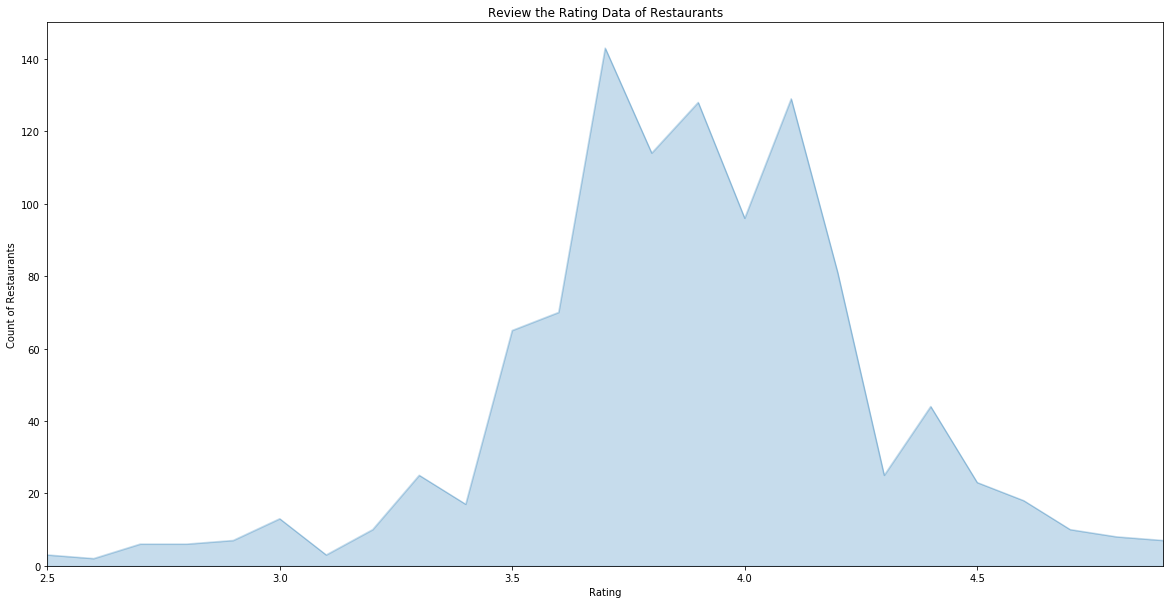

In [33]:
zomato_rating_df = zomato_rest.groupby('Rest_Rating')['Ward'].count()

zomato_rating_df.plot(kind='area', alpha=0.25,
             stacked=True,
             figsize=(20, 10), 
             )

plt.title('Review the Rating Data of Restaurants')
plt.ylabel('Count of Restaurants')
plt.xlabel('Rating')

plt.show()

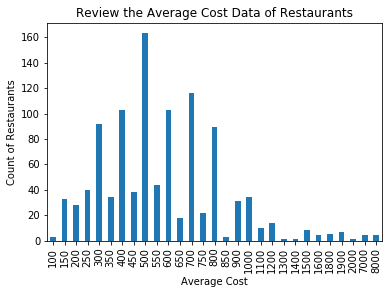

In [39]:
zomato_cost_df = zomato_rest.groupby('Rest_Cost')['Ward'].count()

zomato_cost_df.plot(kind='bar')

plt.title('Review the Average Cost Data of Restaurants')
plt.ylabel('Count of Restaurants')
plt.xlabel('Average Cost')

plt.show()

### Analysis on the wards(neighbourhood) using One Hot Encoding and grouping

(117, 49)


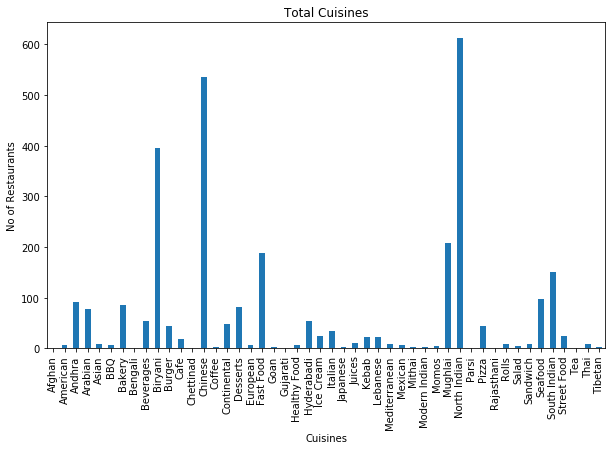

In [26]:
# Restaurant Cuisines based analysis

# Use One Hot Encoding
zom_cuisine_onehot = zomato_rest['Rest_Cuisines'].str.get_dummies(', ')
zom_cuisine_onehot ['Ward'] = zomato_rest['Ward']
fixed_columns = [zom_cuisine_onehot.columns[-1]] + list(zom_cuisine_onehot.columns[:-1])
zom_cuisine_onehot = zom_cuisine_onehot[fixed_columns]

zom_cuisine_grouped = zom_cuisine_onehot.groupby('Ward').mean().reset_index()
print(zom_cuisine_grouped.shape)

cuisinedf = zom_cuisine_onehot.sum()
cuisinedf = cuisinedf.drop('Ward')
cuisinedf.head()

#Plot a Bar Chart of the total Cuisines
cuisinedf.plot(kind='bar', figsize=(10, 6), rot=90)

plt.xlabel('Cuisines')
plt.ylabel('No of Restaurants')
plt.title('Total Cuisines')
plt.show()



In [65]:
# Use One Hot Encoding
zom_cuisine_onehot = zomato_rest['Rest_Cuisines'].str.get_dummies(', ')
zom_cuisine_onehot ['Ward'] = zomato_rest['Ward']
fixed_columns = [zom_cuisine_onehot.columns[-1]] + list(zom_cuisine_onehot.columns[:-1])
zom_cuisine_onehot = zom_cuisine_onehot[fixed_columns]

zom_cuisine_grouped = zom_cuisine_onehot.groupby('Ward').mean().reset_index()
print(zom_cuisine_grouped.shape)


# Top 10 Cuisines in each Ward
def return_most_common_rest(row, num_top_rest):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 20
indicators = ['st', 'nd', 'rd']
columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
zom_cuisine_sorted = pd.DataFrame(columns=columns)
zom_cuisine_sorted['Ward'] = zom_cuisine_grouped['Ward']
for ind in np.arange(zom_cuisine_grouped.shape[0]):
    zom_cuisine_sorted.iloc[ind, 1:] = return_most_common_rest(zom_cuisine_grouped.iloc[ind, :], num_top_venues)

zom_cuisine_sorted.head()


,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Addagutta,Chinese,North Indian,Mughlai,Biryani,Fast Food,Seafood,Bengali,Chettinad,Burger,...,Bakery,Andhra,Beverages,BBQ,Healthy Food,Asian,Cafe,Arabian,Coffee,Continental
1,Adikmet,North Indian,Chinese,Biryani,Mughlai,Seafood,Bakery,Fast Food,Desserts,Hyderabadi,...,Arabian,BBQ,Goan,American,European,Andhra,Continental,Coffee,Chettinad,Bengali
2,Ahmed Nagar,North Indian,Mughlai,Chinese,Arabian,Biryani,Seafood,Fast Food,Andhra,Desserts,...,Lebanese,Burger,Goan,European,Continental,Coffee,Tibetan,Chettinad,Cafe,Healthy Food
3,Allapur,Biryani,Fast Food,Bakery,Desserts,North Indian,Hyderabadi,Chinese,Lebanese,Pizza,...,Tea,South Indian,BBQ,Andhra,European,American,Continental,Coffee,Chettinad,Bengali
4,Allwyn Colony,North Indian,Chinese,Biryani,South Indian,Andhra,Fast Food,Desserts,Burger,Mughlai,...,Beverages,Bengali,Healthy Food,Bakery,BBQ,Cafe,Chettinad,Asian,Coffee,Continental


### Clusterting of the Wards (Neighbourhoods) using K-means after identifing the best k

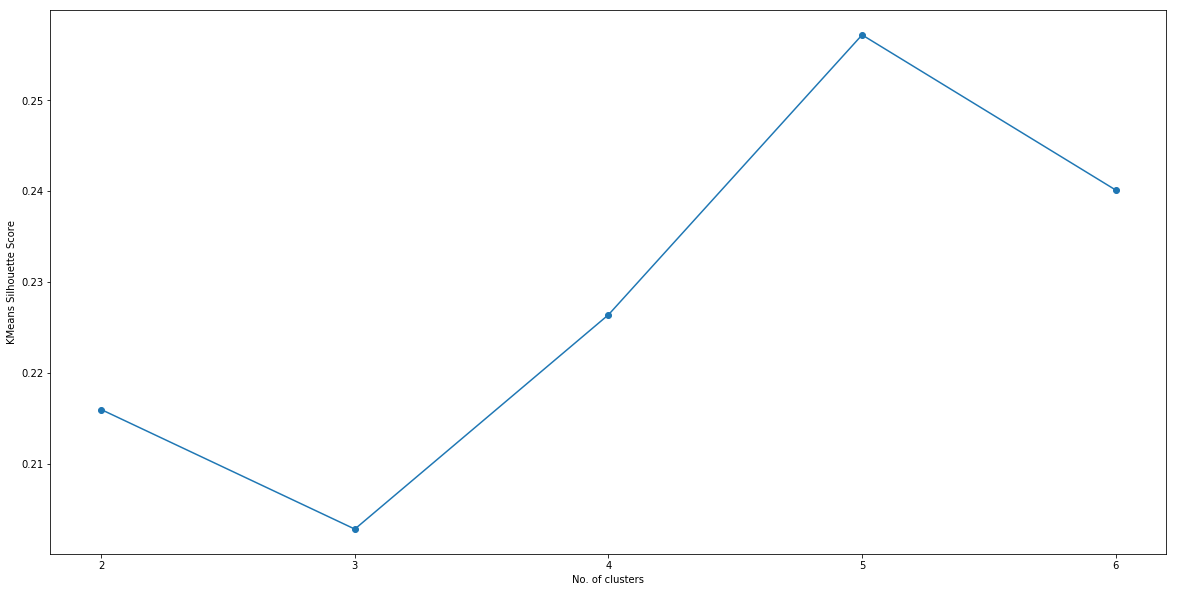

In [69]:
# KMeans Clustering

indices = []
scores = []
max_range = 7

zom_cuisine_grouped_clustering = zom_cuisine_grouped.drop('Ward', 1)
clustering_testing = zom_cuisine_grouped_clustering

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()
    
for kclusters in range(2, max_range) :
    kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit_predict(clustering_testing)
    score = metrics.silhouette_score(clustering_testing, kmeans)
    indices.append(kclusters)
    scores.append(score)

plot(max_range, scores, "No. of clusters", "KMeans Silhouette Score")



In [70]:
# Set number of clusters
kclusters = 5
zom_cuisine_grouped_clustering = zom_cuisine_grouped.drop('Ward', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(zom_cuisine_grouped_clustering)
# check cluster labels generated for each row in the dataframe
print(kmeans.labels_)
zom_cuisine_sorted.insert(0, 'Clusters', kmeans.labels_)

zom_cuisine_merged = zomato_rest
zom_cuisine_merged = zom_cuisine_merged.join(zom_cuisine_sorted.set_index('Ward'), on='Ward')
zom_cuisine_merged.dropna(inplace = True)
zom_cuisine_merged['Clusters'] = zom_cuisine_merged['Clusters'].astype('int32')
                             
zom_cuisine_merged.head()


[0 0 4 1 2 2 0 2 4 2 0 0 0 2 3 1 2 0 2 0 2 2 0 1 0 1 1 3 0 3 0 2 0 1 0 0 1
 4 1 2 0 0 0 2 2 2 1 3 1 2 3 2 0 1 3 4 0 3 2 2 2 2 2 0 2 2 2 1 4 2 1 4 0 0
 1 0 0 3 2 2 2 0 4 1 2 0 0 2 1 1 0 2 1 0 1 1 2 0 2 2 0 2 1 2 1 2 0 0 0 1 0
 2 0 0 2 2 4]


,Ward,Ward_Latitude,Ward_Longitude,Rest_Id,Rest_Name,Rest_Laltitude,Rest_Longitude,Rest_Cuisines,Rest_Cost,Rest_Rating,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Kapra,17.484636,78.561009,90499,Coffee Cup,17.483157,78.552126,"Cafe, Continental, Italian",800,4.5,...,Mughlai,Coffee,Sandwich,Fast Food,Desserts,Chettinad,European,Tibetan,Gujarati,Bengali
1,Kapra,17.484636,78.561009,18715296,Bakasura Restaurant,17.475053,78.563108,"Andhra, South Indian",800,4.0,...,Mughlai,Coffee,Sandwich,Fast Food,Desserts,Chettinad,European,Tibetan,Gujarati,Bengali
2,Kapra,17.484636,78.561009,90201,KFC,17.481579,78.555268,"Fast Food, Burger",450,4.1,...,Mughlai,Coffee,Sandwich,Fast Food,Desserts,Chettinad,European,Tibetan,Gujarati,Bengali
3,Kapra,17.484636,78.561009,18241292,Balaji Santosh Family Dhaba,17.475424,78.564572,North Indian,450,3.9,...,Mughlai,Coffee,Sandwich,Fast Food,Desserts,Chettinad,European,Tibetan,Gujarati,Bengali
4,Kapra,17.484636,78.561009,18682816,Urban Restobar & Lounge,17.484221,78.547823,"Chinese, Continental, North Indian, Italian, C...",1000,4.0,...,Mughlai,Coffee,Sandwich,Fast Food,Desserts,Chettinad,European,Tibetan,Gujarati,Bengali


In [71]:
print(zom_cuisine_merged['Clusters'].value_counts())
zom_cuisine_merged.head()

2    360
0    342
1    207
4     72
3     72
Name: Clusters, dtype: int64


,Ward,Ward_Latitude,Ward_Longitude,Rest_Id,Rest_Name,Rest_Laltitude,Rest_Longitude,Rest_Cuisines,Rest_Cost,Rest_Rating,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Kapra,17.484636,78.561009,90499,Coffee Cup,17.483157,78.552126,"Cafe, Continental, Italian",800,4.5,...,Mughlai,Coffee,Sandwich,Fast Food,Desserts,Chettinad,European,Tibetan,Gujarati,Bengali
1,Kapra,17.484636,78.561009,18715296,Bakasura Restaurant,17.475053,78.563108,"Andhra, South Indian",800,4.0,...,Mughlai,Coffee,Sandwich,Fast Food,Desserts,Chettinad,European,Tibetan,Gujarati,Bengali
2,Kapra,17.484636,78.561009,90201,KFC,17.481579,78.555268,"Fast Food, Burger",450,4.1,...,Mughlai,Coffee,Sandwich,Fast Food,Desserts,Chettinad,European,Tibetan,Gujarati,Bengali
3,Kapra,17.484636,78.561009,18241292,Balaji Santosh Family Dhaba,17.475424,78.564572,North Indian,450,3.9,...,Mughlai,Coffee,Sandwich,Fast Food,Desserts,Chettinad,European,Tibetan,Gujarati,Bengali
4,Kapra,17.484636,78.561009,18682816,Urban Restobar & Lounge,17.484221,78.547823,"Chinese, Continental, North Indian, Italian, C...",1000,4.0,...,Mughlai,Coffee,Sandwich,Fast Food,Desserts,Chettinad,European,Tibetan,Gujarati,Bengali


 ### Plot all the Zomato identified restaurants with color coding for Clusters on the Hyderabad Map

In [13]:
#Create Map of Hyderabad for Venues from Zomato API
#location = geolocator.geocode('Hyderabad, India') #Service Timing out so saving the Latitude and Longitude
kclusters = 5
latitude = 17.3850
longitude = 78.4867
zom_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(zom_cuisine_merged['Rest_Laltitude'].astype('float'), zom_cuisine_merged['Rest_Longitude'].astype('float'), zom_cuisine_merged['Rest_Name'], zom_cuisine_merged['Clusters']):
    label = folium.Popup(str(poi) + '['+ str(cluster)+']', parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(zom_map_clusters)
    
zom_map_clusters

In [14]:
project.save_data(data=zom_cuisine_merged.to_csv(index=False),file_name='zomato_cuisine_clusters.csv',overwrite=True)

zom_cuisine_merged.head()

,Ward,Ward_Latitude,Ward_Longitude,Rest_Id,Rest_Name,Rest_Laltitude,Rest_Longitude,Rest_Cuisines,Rest_Cost,Rest_Rating,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kapra,17.484636,78.561009,90499,Coffee Cup,17.483157,78.552126,"Cafe, Continental, Italian",800,4.5,...,North Indian,Chinese,Continental,Cafe,Andhra,South Indian,Italian,Beverages,Burger,Biryani
1,Kapra,17.484636,78.561009,18715296,Bakasura Restaurant,17.475053,78.563108,"Andhra, South Indian",800,4.0,...,North Indian,Chinese,Continental,Cafe,Andhra,South Indian,Italian,Beverages,Burger,Biryani
2,Kapra,17.484636,78.561009,90201,KFC,17.481579,78.555268,"Fast Food, Burger",450,4.1,...,North Indian,Chinese,Continental,Cafe,Andhra,South Indian,Italian,Beverages,Burger,Biryani
3,Kapra,17.484636,78.561009,18241292,Balaji Santosh Family Dhaba,17.475424,78.564572,North Indian,450,3.9,...,North Indian,Chinese,Continental,Cafe,Andhra,South Indian,Italian,Beverages,Burger,Biryani
4,Kapra,17.484636,78.561009,18682816,Urban Restobar & Lounge,17.484221,78.547823,"Chinese, Continental, North Indian, Italian, C...",1000,4.0,...,North Indian,Chinese,Continental,Cafe,Andhra,South Indian,Italian,Beverages,Burger,Biryani


In [12]:
#Getting csv file from backup and loading as pandas datafarme
zom_cuisine_merged = pd.read_csv(project.get_file('zomato_cuisine_clusters.csv'))
zom_cuisine_merged.head()


,Ward,Ward_Latitude,Ward_Longitude,Rest_Id,Rest_Name,Rest_Laltitude,Rest_Longitude,Rest_Cuisines,Rest_Cost,Rest_Rating,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kapra,17.484636,78.561009,90499,Coffee Cup,17.483157,78.552126,"Cafe, Continental, Italian",800,4.5,...,North Indian,Chinese,Continental,Cafe,Andhra,South Indian,Italian,Beverages,Burger,Biryani
1,Kapra,17.484636,78.561009,18715296,Bakasura Restaurant,17.475053,78.563108,"Andhra, South Indian",800,4.0,...,North Indian,Chinese,Continental,Cafe,Andhra,South Indian,Italian,Beverages,Burger,Biryani
2,Kapra,17.484636,78.561009,90201,KFC,17.481579,78.555268,"Fast Food, Burger",450,4.1,...,North Indian,Chinese,Continental,Cafe,Andhra,South Indian,Italian,Beverages,Burger,Biryani
3,Kapra,17.484636,78.561009,18241292,Balaji Santosh Family Dhaba,17.475424,78.564572,North Indian,450,3.9,...,North Indian,Chinese,Continental,Cafe,Andhra,South Indian,Italian,Beverages,Burger,Biryani
4,Kapra,17.484636,78.561009,18682816,Urban Restobar & Lounge,17.484221,78.547823,"Chinese, Continental, North Indian, Italian, C...",1000,4.0,...,North Indian,Chinese,Continental,Cafe,Andhra,South Indian,Italian,Beverages,Burger,Biryani


In [87]:
# Review Clusters

Review_Clusters_df = pd.DataFrame(index=['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Cluster5'], columns=['Most Common Cuisines', 'Least Common Cuisines'])
cluster = zom_cuisine_merged.loc[zom_cuisine_merged['Clusters'] == 0, zom_cuisine_merged.columns[[0]+list(range(12, zom_cuisine_merged.shape[1]))]]
cluster.drop_duplicates()
print(cluster['1st Most Common Venue'].value_counts(sort =True))
print(cluster['20th Most Common Venue'].value_counts(sort =True))
Review_Clusters_df.loc['Cluster1'] = ["North Indian, Chinese", "Beverages, Burger"]
cluster = zom_cuisine_merged.loc[zom_cuisine_merged['Clusters'] == 1, zom_cuisine_merged.columns[[0]+list(range(12, zom_cuisine_merged.shape[1]))]]
cluster.drop_duplicates()
print(cluster['1st Most Common Venue'].value_counts(sort =True))
print(cluster['20th Most Common Venue'].value_counts(sort =True))
Review_Clusters_df.loc['Cluster2'] = ["Biryani, Bakery, FastFood ", "Burger, Chettinad"]
cluster = zom_cuisine_merged.loc[zom_cuisine_merged['Clusters'] == 2, zom_cuisine_merged.columns[[0]+list(range(12, zom_cuisine_merged.shape[1]))]]
cluster.drop_duplicates()
print(cluster['1st Most Common Venue'].value_counts(sort =True))
print(cluster['20th Most Common Venue'].value_counts(sort =True))
Review_Clusters_df.loc['Cluster3'] = ["North Indian, Chinese", "Bengali, Continental"]
cluster = zom_cuisine_merged.loc[zom_cuisine_merged['Clusters'] == 3, zom_cuisine_merged.columns[[0]+list(range(12, zom_cuisine_merged.shape[1]))]]
cluster.drop_duplicates()
print(cluster['1st Most Common Venue'].value_counts(sort =True))
print(cluster['20th Most Common Venue'].value_counts(sort =True))
Review_Clusters_df.loc['Cluster4'] = ["North Indian, South Indian", "Bengali, Biryani"]
cluster = zom_cuisine_merged.loc[zom_cuisine_merged['Clusters'] == 4, zom_cuisine_merged.columns[[0]+list(range(12, zom_cuisine_merged.shape[1]))]]
cluster.drop_duplicates()
print(cluster['1st Most Common Venue'].value_counts(sort =True))
print(cluster['20th Most Common Venue'].value_counts(sort =True))
Review_Clusters_df.loc['Cluster5'] = ["North Indian", "Healthy Food"]

North Indian    261
Chinese          81
Name: 1st Most Common Venue, dtype: int64
Beverages      72
Burger         63
Bengali        27
Chettinad      27
Andhra         27
Bakery         27
BBQ            27
Gujarati       18
Cafe           18
Continental     9
Arabian         9
Coffee          9
Asian           9
Name: 20th Most Common Venue, dtype: int64
Biryani         99
Bakery          36
Fast Food       36
South Indian    18
Arabian         18
Name: 1st Most Common Venue, dtype: int64
Burger       81
Chettinad    45
Coffee       27
Bengali      27
Gujarati     18
Andhra        9
Name: 20th Most Common Venue, dtype: int64
North Indian    198
Chinese         144
Biryani          18
Name: 1st Most Common Venue, dtype: int64
Bengali         81
Continental     81
Cafe            45
Beverages       36
BBQ             36
Burger          27
Bakery          27
Healthy Food     9
Arabian          9
Coffee           9
Name: 20th Most Common Venue, dtype: int64
North Indian    45
South India

### Results of the Clustering

In [88]:
Review_Clusters_df

,Most Common Cuisines,Least Common Cuisines
Cluster1,"North Indian, Chinese","Beverages, Burger"
Cluster2,"Biryani, Bakery, FastFood","Burger, Chettinad"
Cluster3,"North Indian, Chinese","Bengali, Continental"
Cluster4,North Indian,"Bengali, Biryani"
Cluster5,North Indian,Healthy Food


### Discussion

#### The above identified cuisines and the location clusters based on the wards and neighbourhoods can be used to identify a suitable combination of the cuisine and location for a restaurant recommendation
##### - If there is a preferred location identified the corresponding cluster of that location can be reviewed and either the least common cuisine can be opened there to improve probablity of sucess and profits
##### - If there is a preferred cuisine identified all the clusters can be reviewed to identify the clusters with least number of restaurants of this cuisine and choose neighbourhood\ward that can imporve probability of sucess and profits.





### Conclusion and Future

The Conclusion is that we are able to build a recommendation system for restaurants based on cuisines and location; but with limited data and a simplistic model.
We have only sourced top 10 restaurants from Zomato; and there are opportunities of getting all of the location which can go to 100+ per neighbourhood.
Additional Zomato API has availability of rating, cost, voters, details of restaurants like delivery, dine in offers etc, 
which all can help provide additional details for  more complex data model and more comprehensive recommendation model.